# Structure

~~Are there more raids in some areas than others?~~

~~**~factoid** Where are there a lot of raids? Is that interesting? confounder: population]

Where is there a high # and high % of raids? Where are there high raids/low pop and high pop/low raids?

**interaction** Why are there more raids in some places than others?

**trend** In general, are there more or less raids now than in 2014?

**comparison** Where are there local anti-raids groups?

**factoid** What extra detail can we get? (e.g. past FOI data with cop accompaniment)

Could do a [time slider choropleth](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/TimeSliderChoropleth.ipynb) - but not sure what it adds?

### Background

We put in Freedom Of Information (FOI) requests to **??**, to detail on raids over the last few years. We managed to get back how many immigration raids have happened, broken down by year and by "postcode district", the first bit of the postcode (e.g. N15, E6).

In [56]:
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')

first_yr = 2014
last_yr = 2018
yr_range = str(first_yr) + '-' + str(last_yr)

### Are there more raids in some areas than others?

In [57]:
raids_by_year = pd.read_csv('Data\\LondonRaidsByYear.csv', index_col=["PostDist"])
full_yrs = [str(yr) for yr in range(first_yr, last_yr+1)]
raids_by_year = raids_by_year[full_yrs]
raids_by_year.loc[:,'Total'] = raids_by_year.sum(axis=1)
# print(raids_by_year)
print('How many districts:',len(raids_by_year))

How many districts: 130


The spread of immigration raids is quite uneven. If you look at how many districts have 0-99 raids, 100-199 raids, etc. it's most common for districts to have less than 100 raids...

Text(0, 0.5, 'Number of districts')

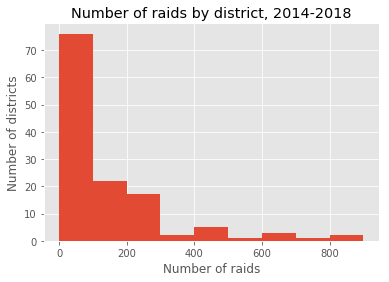

In [62]:
raids_by_year['Total'].plot.hist(bins=[100*n for n in range(10)])
plt.title('Number of raids by district, ' + yr_range)
plt.xlabel('Number of raids')
plt.ylabel('Number of districts')

...but overall, about a quarter of London districts have had 200+ raids over the last few years.

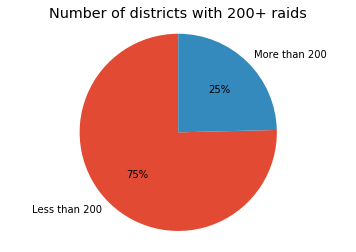

In [59]:
cutoff = 200
str_cutoff = str(cutoff)
labels = ['Less than '+str_cutoff, 'More than '+str_cutoff]
sizes = [len(raids_by_year['Total'][raids_by_year['Total'] < cutoff])]
sizes += [len(raids_by_year['Total'][raids_by_year['Total'] >= cutoff])]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90)
ax1.axis('equal')
ax1.set_title('Number of districts with ' + str_cutoff + '+ raids')
plt.show()

### Where are there the most raids?

There is no obvious "huge outlier", where there are loads more raids happening in one specific district. For example, you could look at the top 5 districts for number of raids:

In [60]:
raids_by_year.sort_values('Total', ascending=False).head(5)

,2014,2015,2016,2017,2018,Total
PostDist,,,,,,
E6,328.0,219.0,209.0,204.0,157.0,1117.0
E7,224.0,204.0,186.0,165.0,121.0,900.0
SE1,87.0,137.0,214.0,279.0,161.0,878.0
SE18,177.0,219.0,166.0,121.0,78.0,761.0
E13,115.0,125.0,177.0,131.0,130.0,678.0


But practically, it's skewed because some districts are bigger than others. There's a strong correlation between number of raids and number of people in a district.

Text(0, 0.5, 'Raids')

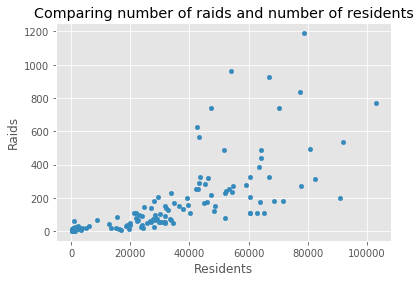

In [76]:
raid_popn = pd.read_csv('Data\\PopnRaidsRate.csv', index_col=['Postcode'])
# print(raid_popn)
raid_popn.plot.scatter('Residents', 'Count')
plt.title('Comparing number of raids and number of residents')
plt.ylabel('Raids')
# raid_popn.corr().loc['Count', 'Residents'] ~= 0.7

Where has a high number, _and_ a high rate of raids?

In [86]:
raid_popn['Scale'] = raid_popn['Count'] * raid_popn['Rate']
raid_popn.sort_values('Scale', ascending=False).head(20)[['Residents', 'Count', 'Rate']]
# Idea: display as a map - a diverging/diverging map

,Residents,Count,Rate
Postcode,,,
E6,78790.0,1189.0,15.090748
E7,54133.0,964.0,17.807991
SE1,67037.0,926.0,13.813267
E13,47169.0,737.0,15.624669
E12,42606.0,625.0,14.669295
SE18,77384.0,836.0,10.803267
E1,70389.0,738.0,10.484593
E10,43120.0,564.0,13.079777
E17,103129.0,769.0,7.456680


Where are there high raids/low pop and high pop/low raids?

In [ ]:
# Same as above - bivariate choropleth?